### Code block 1: Package initialization
Import required packages, do not change.

In [1]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple


### Code block 2: Useful classes
Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), do not change.

In [2]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)

    def forward(self, input):
        self.input = input
        # 'pytorch 2.0'
        self.output = super().forward(input)
        return self.output

class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)

    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

## Lab 2

### Code block 3: SimpleNN implementation

Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**

In [3]:
"""
Lab 2(a)
Build the SimpleNN model by following Table 1
"""

# Create the neural network module: LeNet-5
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer definition
        self.conv1 = CONV(3, 16, 5, 1, padding = 2)
        self.conv2 = CONV(16, 16, 3, 1, padding = 2)
        self.conv3 = CONV(16, 32, 7, 1, padding = 2)
        self.fc1   = FC(32 * 3 * 3, 32)
        self.fc2   = FC(32, 10)

    def forward(self, x):
        # Forward pass computation
        # Conv 1
        out = F.relu(self.conv1(x))
        # MaxPool
        out = F.max_pool2d(out, kernel_size = 4, stride = 2)
        # Conv 2
        out = F.relu(self.conv2(out))
        # MaxPool
        out = F.max_pool2d(out, kernel_size = 3, stride = 2)
        # Conv 3
        out = F.relu(self.conv3(out))
        # MaxPool
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        # Flatten
        out = torch.flatten(out, 1)
        # FC 1
        out = F.relu(self.fc1(out))
        # FC 2
        out = self.fc2(out) #shouldn't these be like %s? Is the relu also applied to this layer? no.
        return out

# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition
net = SimpleNN()
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out"
out = net(data)

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")

Run on CPU...
Forward pass successful


### Code block 4: Shape observation
Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**. Gather the printed results in Table 2 in your report.

In [8]:
"""
Lab 2(b)
"""
# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)
# Forward pass "data" through "net" to get output "out"
out = net(data)

import pandas as pd
df = pd.DataFrame(columns = ['Layer', 'Input shape', 'Output shape', 'Weight shape', '# Param', '# MAC'])

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the input feature map of the module as a NumPy array
        input = module.input
        # Get the output feature map of the module as a NumPy array
        output = module.output
        # Get the weight of the module as a NumPy array
        if isinstance(module, CONV):
          weight = module.weight
        if isinstance(module, FC):
          weight = torch.cat([module.weight, module.bias[:, None]], axis = -1)
        # Compute the number of parameters in the weight
        num_Param = sum(p.numel() for p in module.parameters())
        # Compute the number of MACs in the layer
        if isinstance(module, CONV):
          C_1 = module.in_channels
          K = module.kernel_size[0]
          C_2 = module.out_channels
          H_2 = output.size(dim=2)
          W_2 = output.size(dim=3)
          num_MAC = C_1 * K * K * C_2 * H_2 * W_2
        if isinstance(module, FC):
          num_MAC = 2 * num_Param

        df.loc[len(df.index)] = [name, input.shape, output.shape, weight.shape, num_Param, num_MAC]

        print(f'{name:10} {str(input.shape):20} {str(output.shape):20} {str(weight.shape):20} {str(num_Param):10} {str(num_MAC):10}')


conv1      torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 32, 32]) torch.Size([16, 3, 5, 5]) 1200       1228800   
conv2      torch.Size([1, 16, 15, 15]) torch.Size([1, 16, 17, 17]) torch.Size([16, 16, 3, 3]) 2304       665856    
conv3      torch.Size([1, 16, 8, 8]) torch.Size([1, 32, 6, 6]) torch.Size([32, 16, 7, 7]) 25088      903168    
fc1        torch.Size([1, 288]) torch.Size([1, 32])  torch.Size([32, 289]) 9248       18496     
fc2        torch.Size([1, 32])  torch.Size([1, 10])  torch.Size([10, 33]) 330        660       


In [9]:
df

,Layer,Input shape,Output shape,Weight shape,# Param,# MAC
0,conv1,"(1, 3, 32, 32)","(1, 16, 32, 32)","(16, 3, 5, 5)",1200,1228800
1,conv2,"(1, 16, 15, 15)","(1, 16, 17, 17)","(16, 16, 3, 3)",2304,665856
2,conv3,"(1, 16, 8, 8)","(1, 32, 6, 6)","(32, 16, 7, 7)",25088,903168
3,fc1,"(1, 288)","(1, 32)","(32, 289)",9248,18496
4,fc2,"(1, 32)","(1, 10)","(10, 33)",330,660


## Lab 3 (Bonus)

### Code block 5: Initial weight histogram
Please follow the instructions in Lab 3(a) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

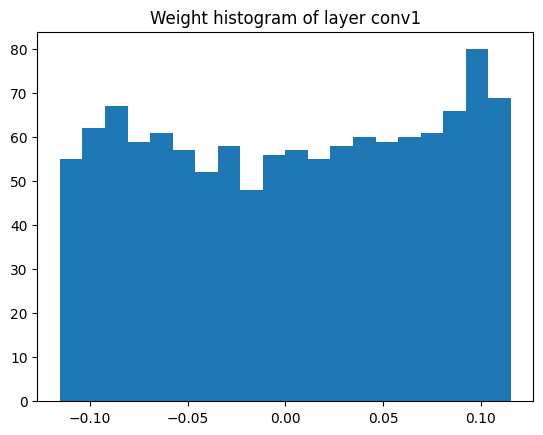

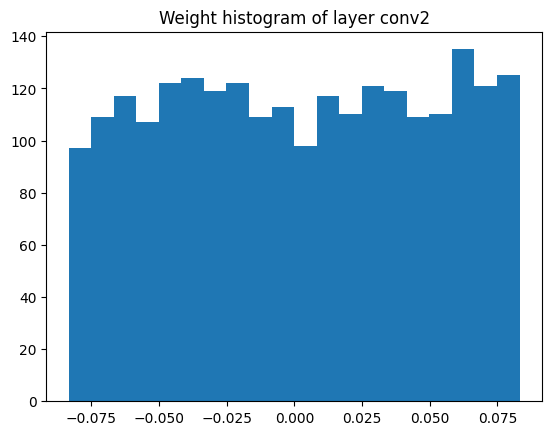

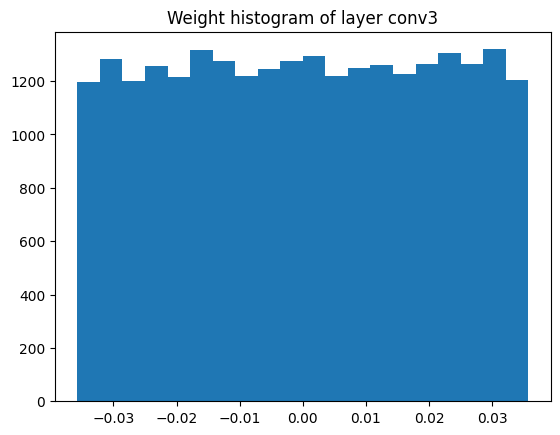

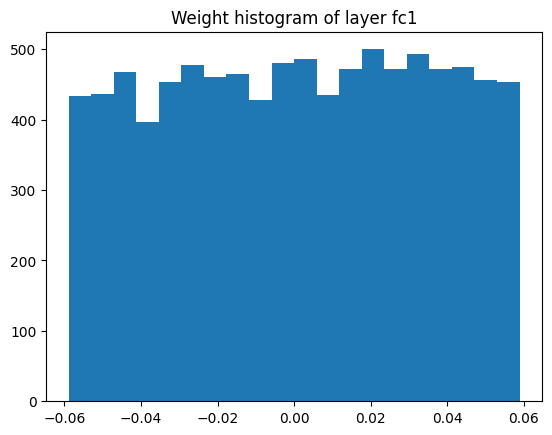

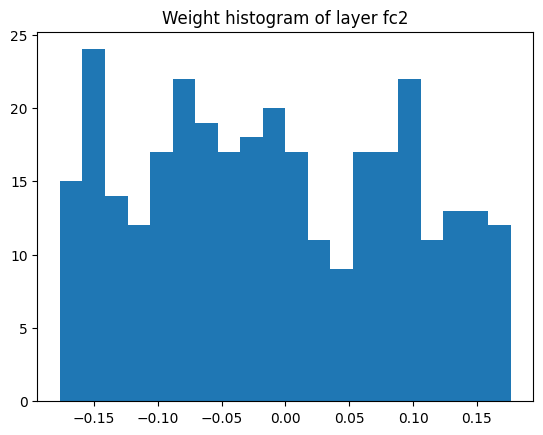

In [13]:
"""
Lab 3(a)
"""
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().numpy()

        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

### Code block 6: Gradient histogram
Please follow the instructions in Lab 3(b) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

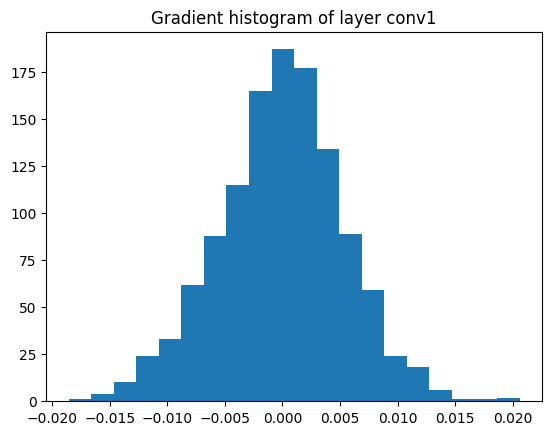

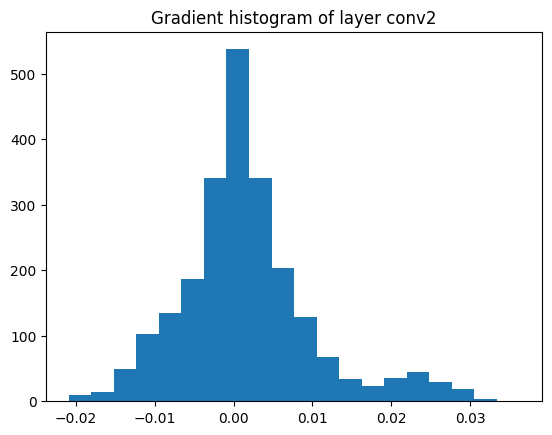

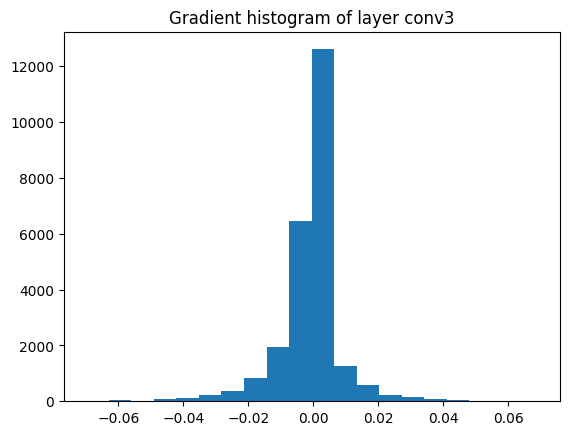

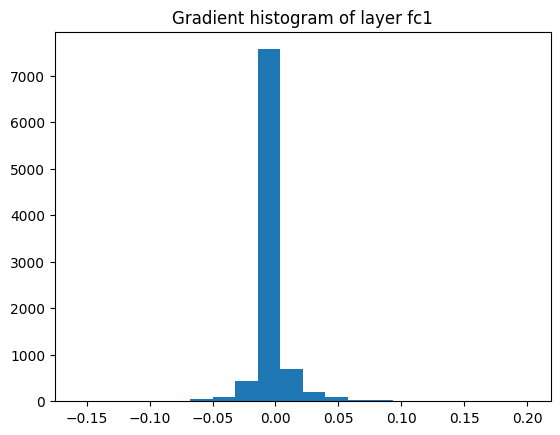

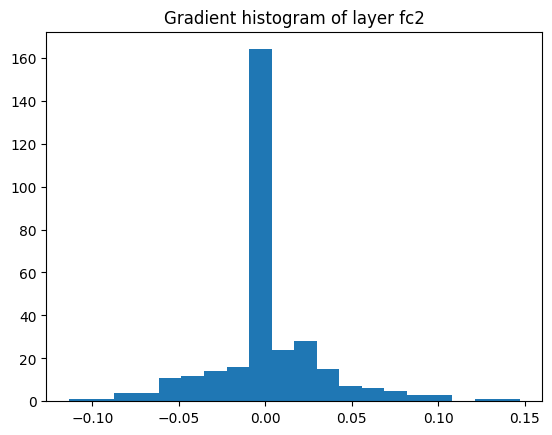

In [15]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()
# Random target
target = torch.randn(1, 10).to(device)

# Loss computation
loss = criterion(out, target)
#optimizer = optim.SGD(net.parameters(requires_grad = True), lr = 0.01, momentum = 0.9, weight_decay = 1e-4)
# Backward pass for gradients
#optimizer.zero_grad()
loss.backward()
#optimizer.step()


for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient =  module.weight.grad

        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()


### Code block 7: Zero initialization?
Please follow the instructions in Lab 3(c) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

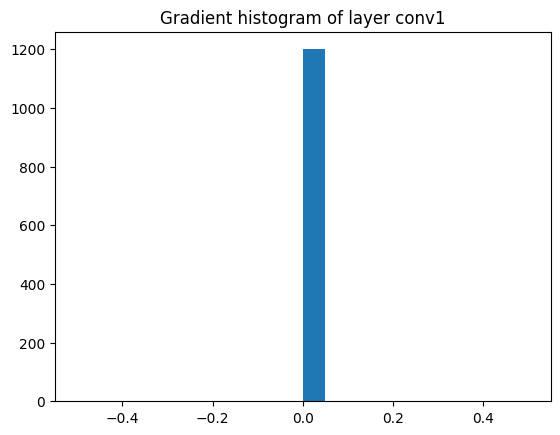

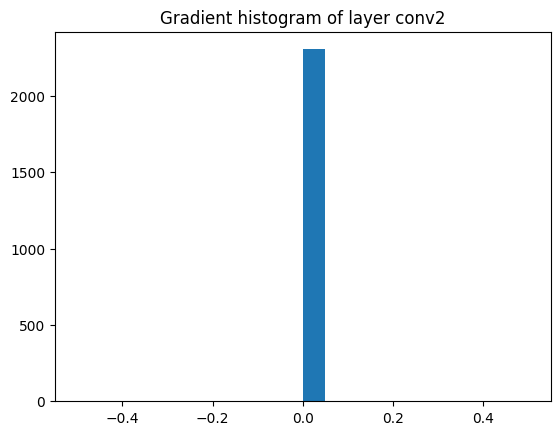

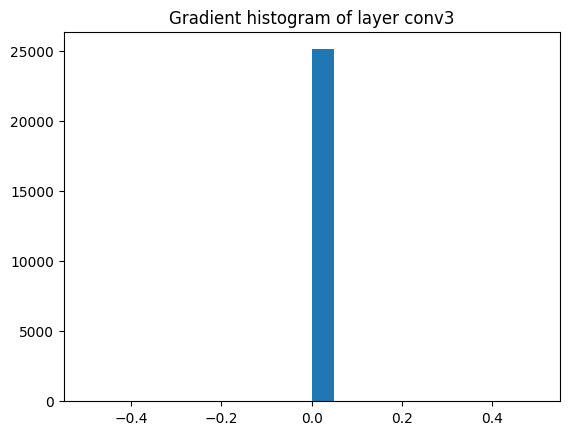

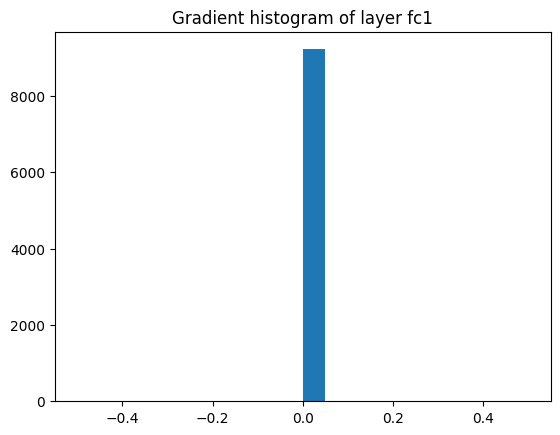

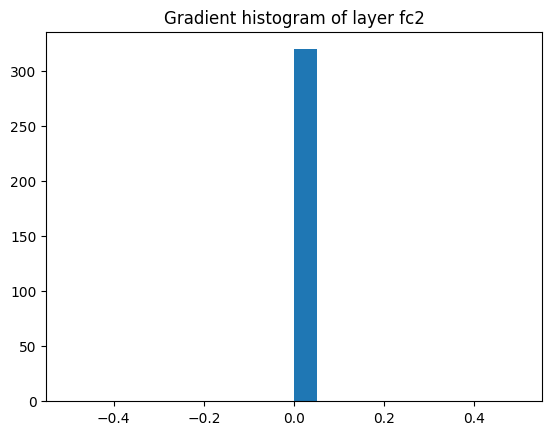

In [16]:
'''
Lab 3(c)
'''
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Set the weight of each module to all zero
        module.weight.data.zero_()
        if isinstance(module, FC):
          module.bias.data.zero_()

# Reset gradients
net.zero_grad()

# Forward and backward pass
# Random data and target
data = torch.randn(1,3,32,32).to(device)
target = torch.randn(1, 10).to(device)

# Forward pass
out = net(data)
# Loss computation
loss = criterion(out, target)
# Backward pass
loss.backward()

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad

        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()